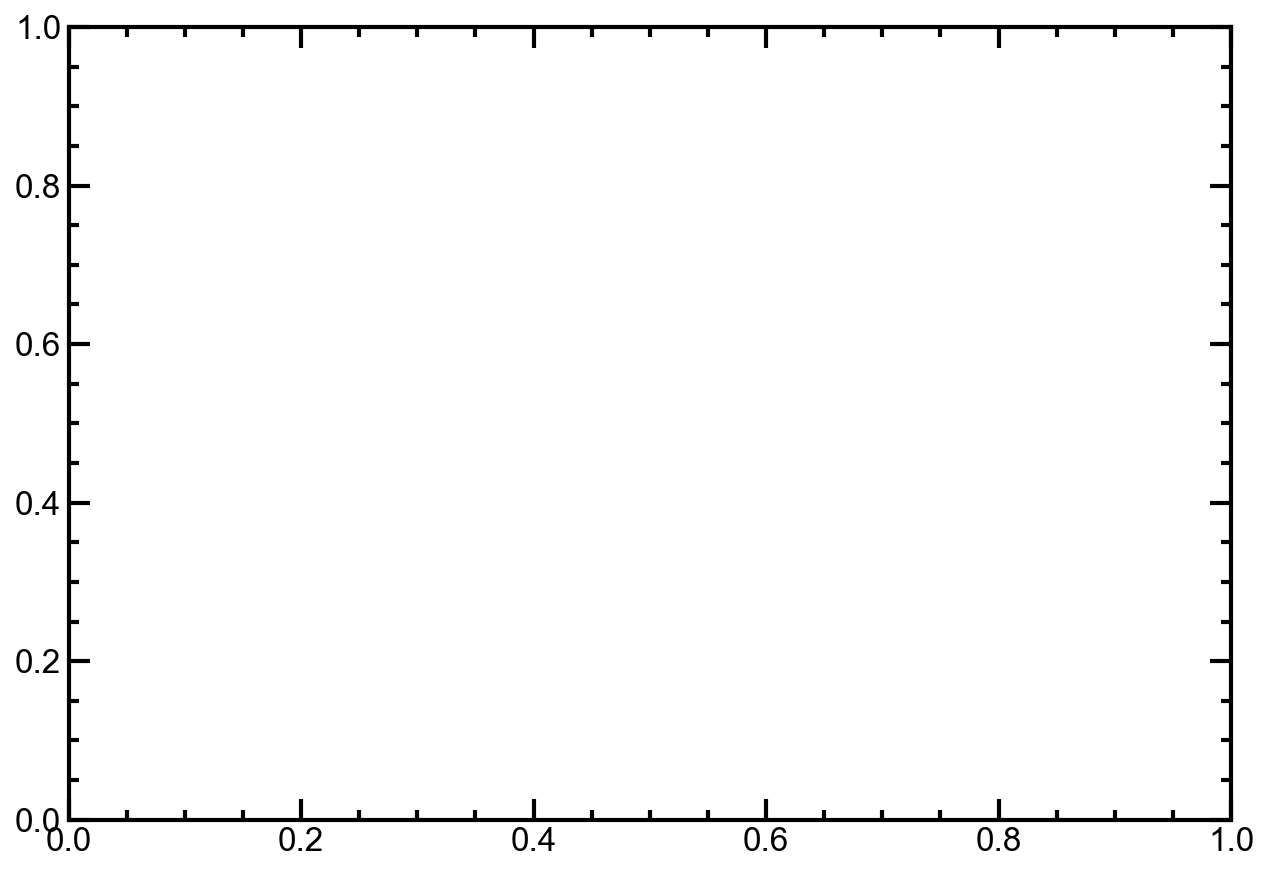

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import *
import scqubits as scq
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from matplotlib import rcParams
rcParams['lines.linewidth'] = 1
import matplotlib.ticker as tck

In [2]:
savefig = True
if savefig == True:
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
else:
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.serif'] = ['Arial']
    
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/SCQ summary/'

## Flux qubit

Generally, we can think about an inductively shunted qubit as a system with the Hamiltonian
$$
H = 4E_C(n-n_g)^2 +\frac{1}{2}E_L\varphi^2 - E_J\cos(\varphi-\varphi_\mathrm{ext})
$$
Note that this Hamiltonian describes most precisely the original single-junction flux qubit.

The more popular flux qubit version has three junctions, with one smaller than the other by a factor $0.5<\alpha<1$. We explore that below

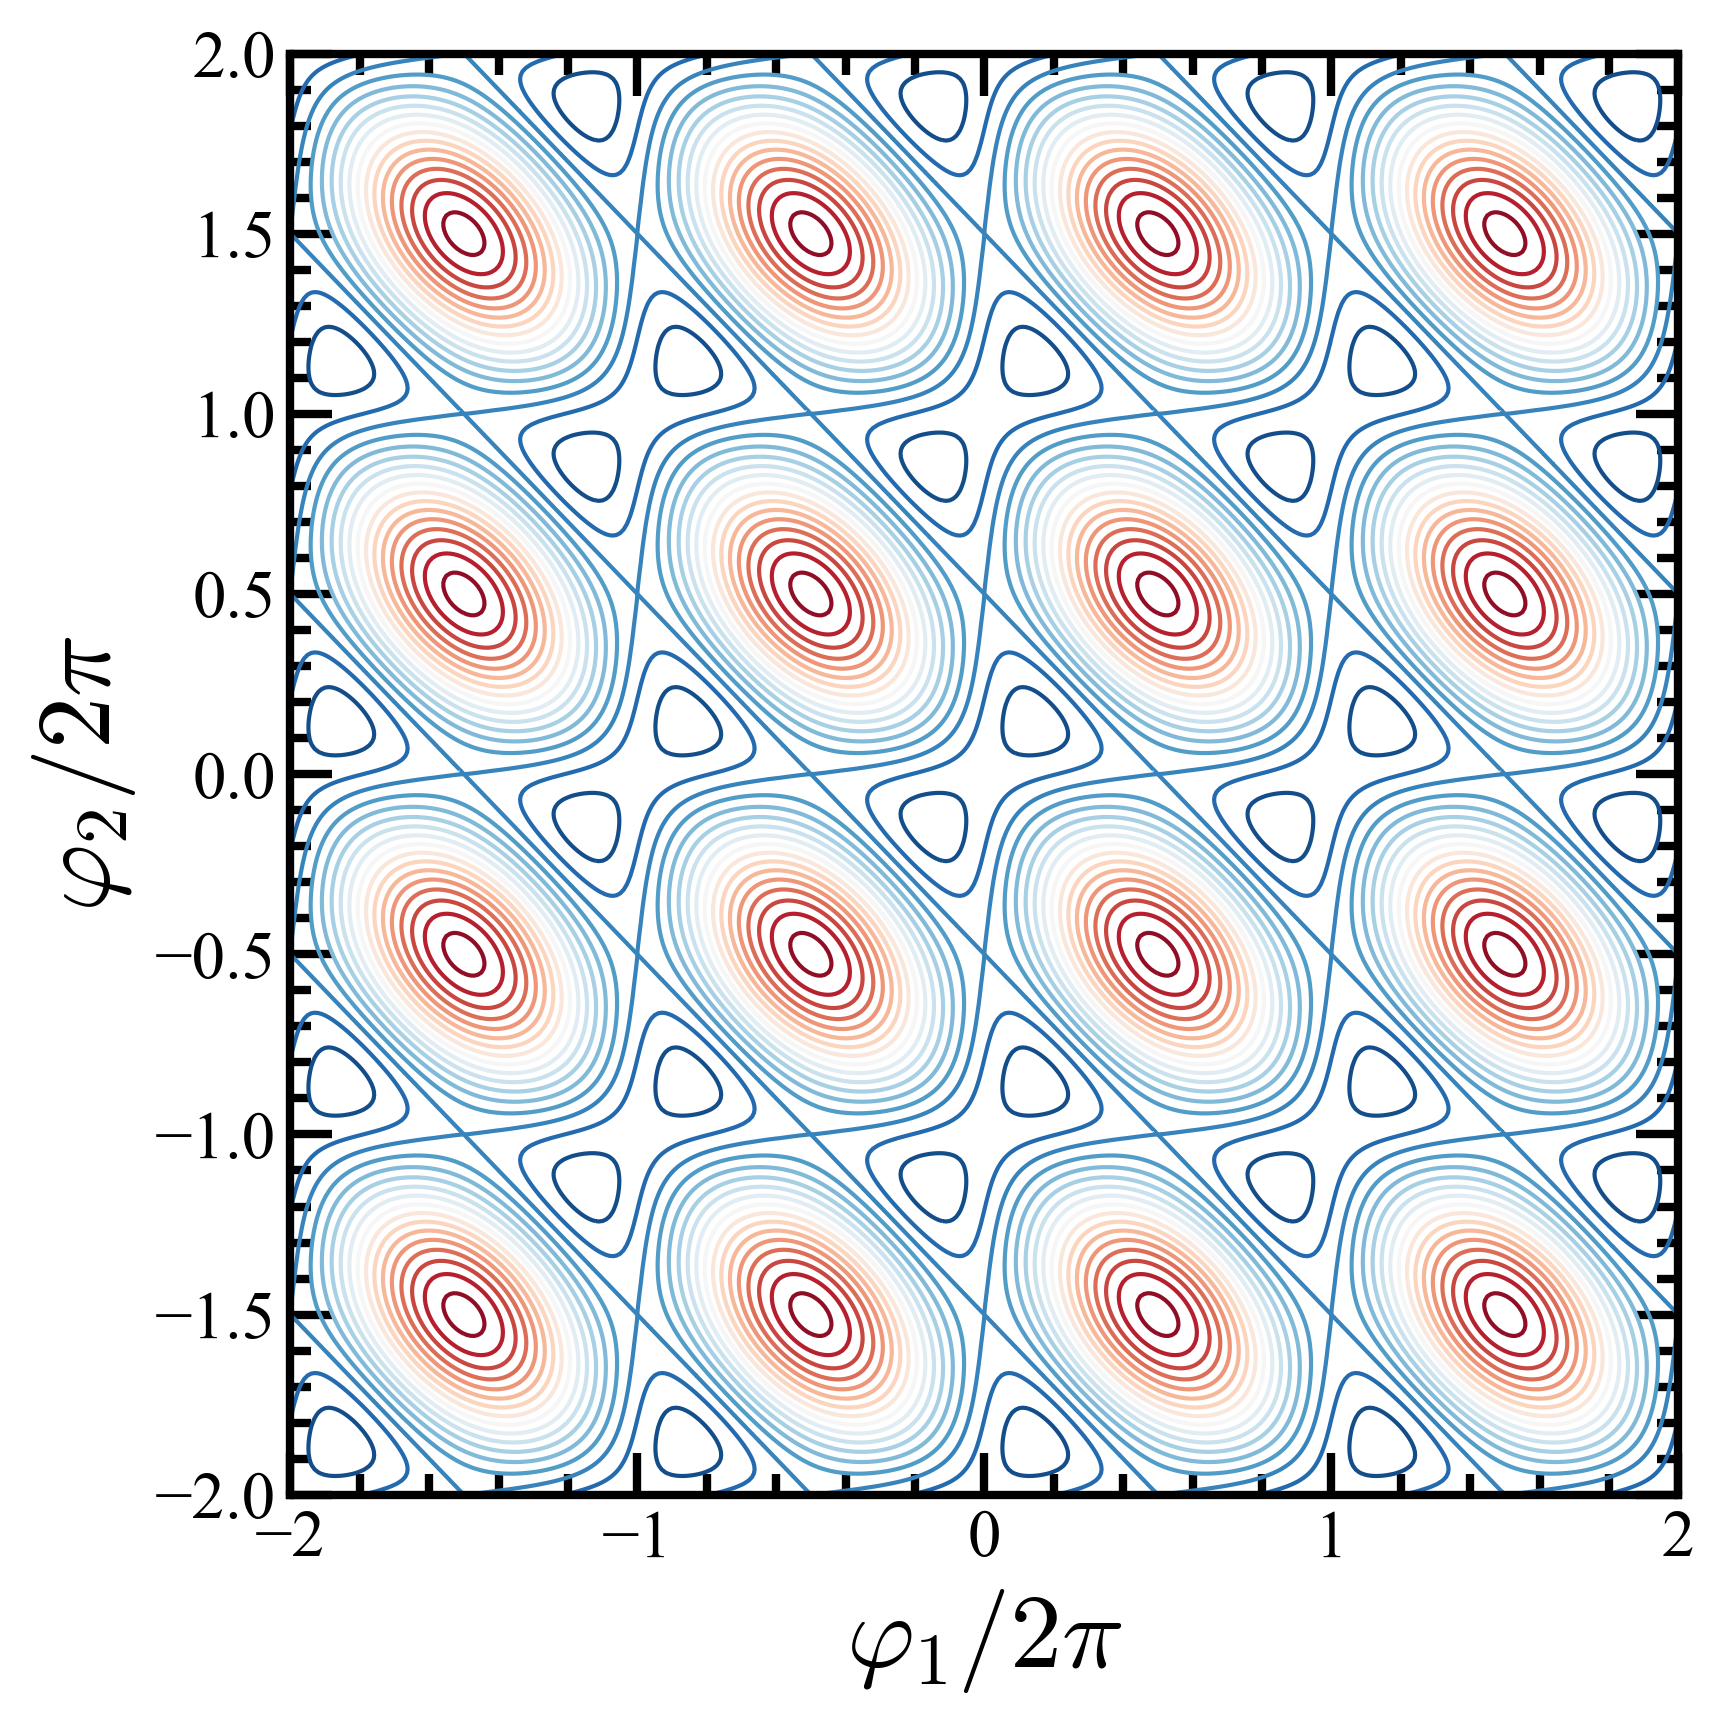

In [3]:
def fluxq_potential(phi1, phi2, E_J, alpha, phi_ext):
    return alpha-E_J*(np.cos(phi1)+np.cos(phi2)) - alpha*E_J*np.cos(phi1+phi2+phi_ext)

phi1 = np.linspace(-4,4,401)*np.pi
phi2 = np.linspace(-4,4,401)*np.pi
E_J = 1
alpha = 0.8
phi_ext = 0.5*np.pi*2
V = np.zeros((len(phi1), len(phi2)))
for idx1, p1 in enumerate(phi1):
    for idx2, p2 in enumerate(phi2):
        V[idx1, idx2] = fluxq_potential(p1, p2, E_J, alpha, phi_ext)
plt.figure(figsize = [6,6])        
X,Y = np.meshgrid(phi1/np.pi/2,phi2/np.pi/2)
Z = V
plt.contour(X,Y,Z, 20, cmap = 'RdBu_r')
# plt.colorbar()
plt.xlabel(r'$\varphi_1/2\pi$')
plt.ylabel(r'$\varphi_2/2\pi$')
plt.tight_layout()
if savefig == True:
    figname = 'flux_alpha=0.8.pdf'
    plt.savefig(figpath+figname)

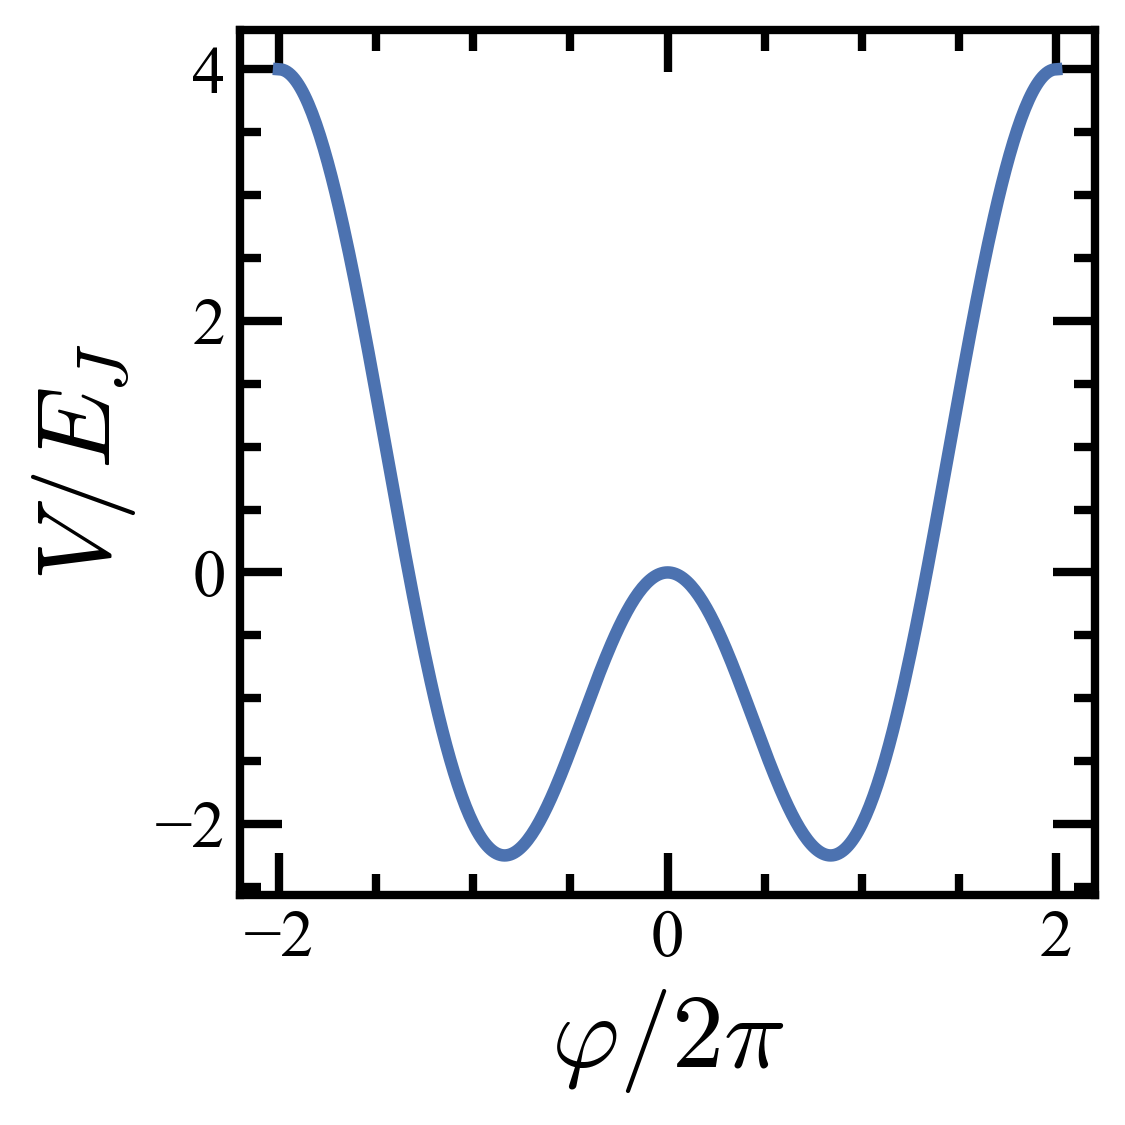

In [4]:
def potential_gen(phi,E_J,N,alpha):
    return -E_J*(N*np.cos(phi/N) - alpha*np.cos(phi))

phi = np.linspace(-1,1,401)*2*np.pi
E_J = 1
N=2
alpha = 2
V = potential_gen(phi,E_J,N,alpha)
plt.figure(figsize = [4,4])
plt.plot(phi/np.pi, V/E_J, linewidth = 3)
plt.xlabel(r'$\varphi/2\pi$')
plt.ylabel(r'$V/E_J$')
plt.tight_layout()
if savefig == True:
    figname = 'flux_alpha=2.pdf'
    plt.savefig(figpath+figname)

## Exact model
First, full circuit model with two different $E_C$'s. Capacitors across the large junctions go as $C(1+\alpha)C$ where as one across the small junction goes as $\alpha C$

In [5]:
# parameters for the flux qubit
RATIO = 60.0
ALPHA = 0.8

flux_qubit = scq.FluxQubit(
    EJ1 = 10.0, 
    EJ2 = 10.0, 
    EJ3 = ALPHA*10.0, 
    ECJ1 = 1.0/RATIO, 
    ECJ2 = 1.0/RATIO, 
    ECJ3 = 1.0/ALPHA/RATIO, 
    ECg1 = 50.0/RATIO, 
    ECg2 = 50.0/RATIO, 
    ng1 = 0.0, 
    ng2 = 0.0, 
    flux = 0.4, 
    ncut = 10,
)

print(flux_qubit._evals_calc(evals_count=10))
phi_ext_array = np.linspace(0.45,0.55,1001)
energies_full = np.zeros((len(phi_ext_array), 10))
for idx, phi_ext in enumerate(phi_ext_array):
    flux_qubit = scq.FluxQubit(
    EJ1 = 10.0, 
    EJ2 = 10.0, 
    EJ3 = ALPHA*10.0, 
    ECJ1 = 1.0/RATIO, 
    ECJ2 = 1.0/RATIO, 
    ECJ3 = 1.0/ALPHA/RATIO, 
    ECg1 = 50.0/RATIO, 
    ECg2 = 50.0/RATIO, 
    ng1 = 0.0, 
    ng2 = 0.0, 
    flux = phi_ext, 
    ncut = 10,
)
    energies_full[idx:] = flux_qubit._evals_calc(evals_count=10)
    
# flux_list = np.linspace(0.45, 0.55, 101)
# flux_qubit.plot_evals_vs_paramvals('flux', flux_list, evals_count=5, subtract_ground=True);

[-17.93586089 -17.05540004 -16.97047136 -16.17999185 -16.07937456
 -16.01629457 -15.29382395 -15.16683871 -15.10346523 -15.07193432]


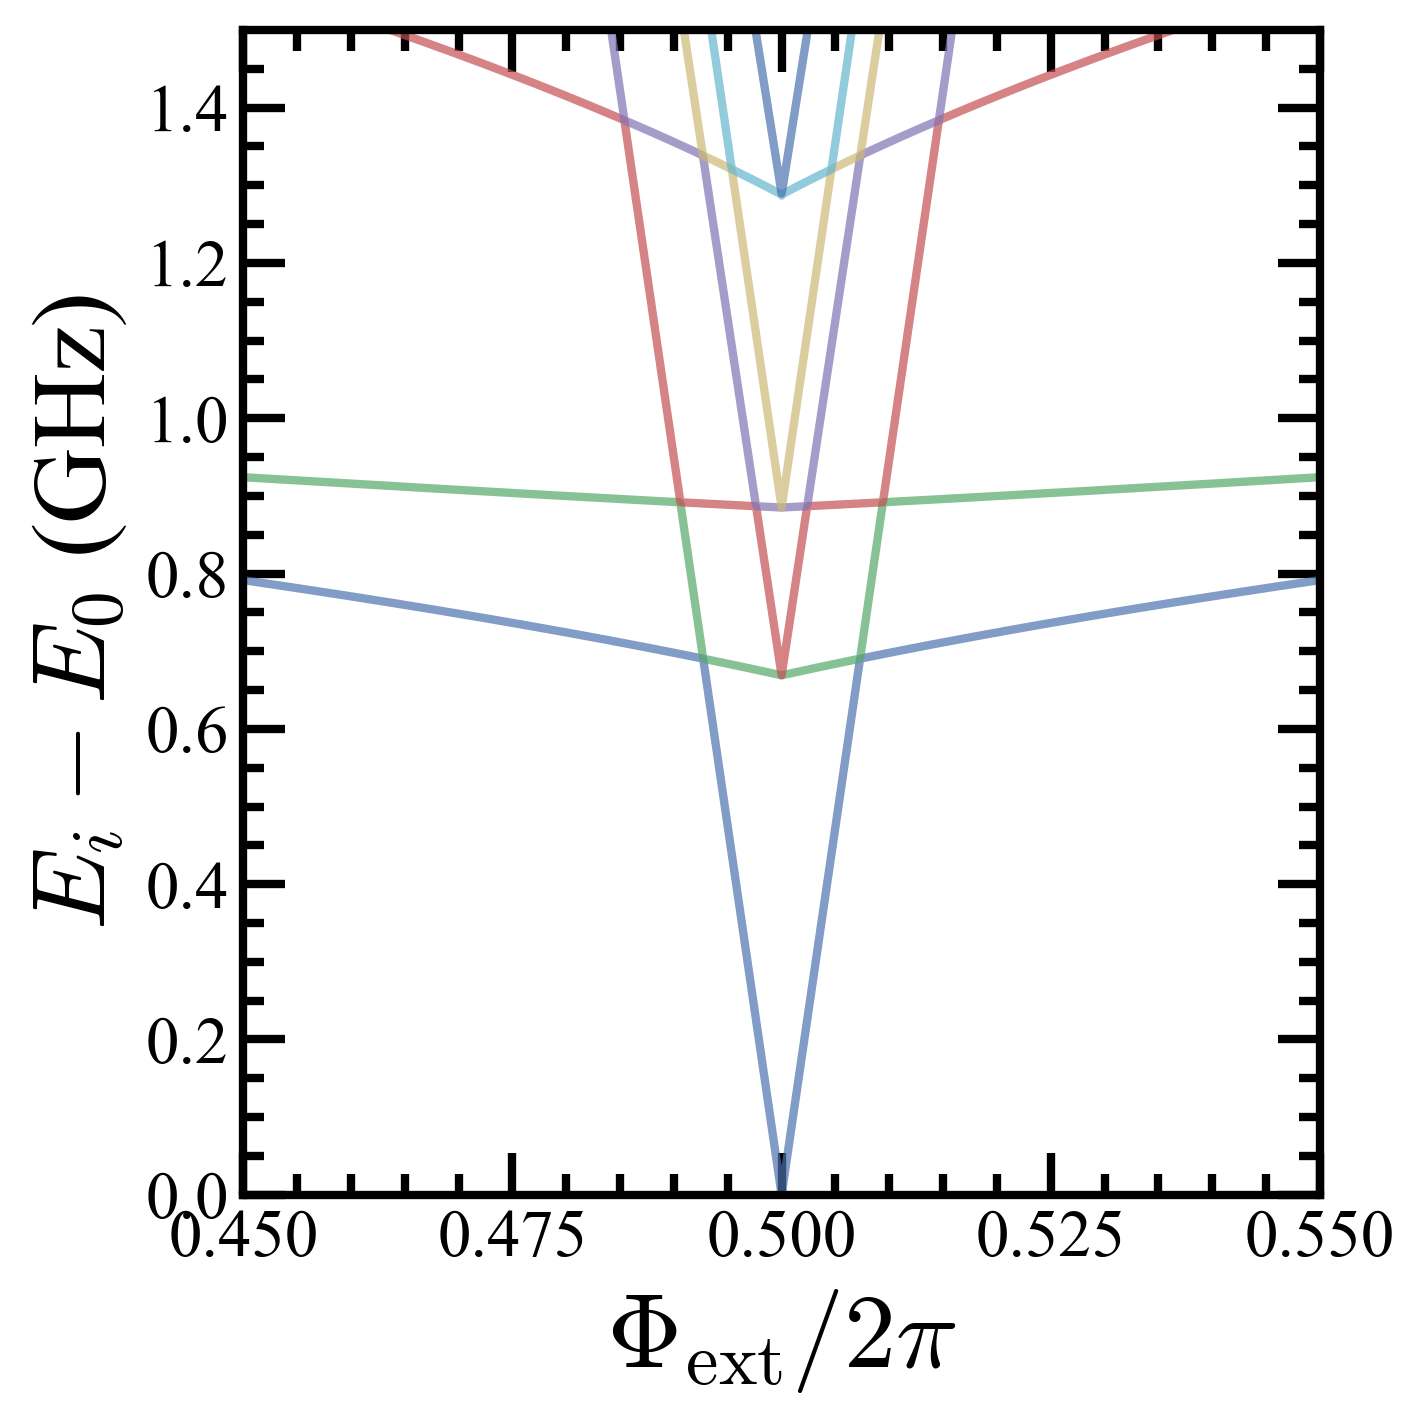

In [6]:
plt.figure(figsize = [5,5])
for idx in range(1,10):
    plt.plot(phi_ext_array, energies_full[:,idx]-energies_full[:,0], linewidth = 2.0, alpha = 0.7)
plt.ylim([0,1.5])
plt.xlabel(r'$\Phi_\mathrm{ext}/2\pi$')
plt.ylabel(r'$E_i - E_0$ (GHz)')
plt.xlim([phi_ext_array[0], phi_ext_array[-1]])
plt.tight_layout()
if savefig == True:
    figname = 'flux_exact.pdf'
    plt.savefig(figpath+figname)

## Approximation
Now we check different approximations to see how good they are.

In [7]:
#Full hamiltonian. Use charge basis
dim = 20
iden = np.eye(dim+1)
npts = np.arange(-dim/2,dim/2+1, dtype = complex)
nmatrix = np.diag(npts)
n1_op = np.kron(nmatrix, iden)
n2_op = np.kron(iden, nmatrix)

off_diag_elements = np.ones(dim, dtype=complex)
e_iphi_matrix = np.diag(off_diag_elements, k=1)
e_miphi_matrix = np.diag(off_diag_elements, k=-1)

exp_i_phi1 = np.kron(e_iphi_matrix, iden)
exp_i_phi2 = np.kron(iden, e_iphi_matrix)

cosphi1 = 0.5*(exp_i_phi1 + exp_i_phi1.T)
cosphi2 = 0.5*(exp_i_phi2 + exp_i_phi1.T)

def flux_q_hamiltonian_full(E_J,E_C,E_Ccross,alpha,phi_ext):
    cosphi3 = 0.5*(exp_i_phi1*exp_i_phi2*np.exp(1j*phi_ext) + exp_mi_phi1*exp_mi_phi2*np.exp(-1j*phi_ext))
    H = 4*E_C*(np.matmul(n1_op, n1_op) +np.matmul(n2_op, n2_op)) + 4*E_Ccross*np.matmul(n1_op, n2_op)
    - E_J*(cosphi1 + cosphi2 + alpha*cosphi3)
    return H

alpha = 0.8
ratio = 60
E_J = 10
E_C = E_J/ratio
E_Ccross = 2*E_C/alpha*(1+alpha)
phi_ext_array = np.linspace(0,1,51)*np.pi*2.0    
energies = np.zeros((len(phi_ext_array), 10))
for idx, phi_ext in enumerate(phi_ext_array):
    H = flux_q_hamiltonian_full(E_J,E_C, E_Ccross,alpha,phi_ext)
    evals = sp.linalg.eigh(H, eigvals=(0, 9), eigvals_only=True)
    sort_evals = np.sort(evals)
    for idy in range(10):
        energies[idx,idy] = sort_evals[idy]
plt.figure(figsize = [5,4])
for idx in range(0,10):
    plt.plot(phi_ext_array / 2 / np.pi, energies[:,idx], linewidth = 1.0, alpha = 0.3)
plt.ylim([0,1.5])
plt.xlabel(r'$\Phi_\mathrm{ext}/2\pi$')
plt.ylabel(r'$E_i - E_0$ (GHz)')

NameError: name 'exp_mi_phi1' is not defined

In [8]:
# Approximate with single degree of freedom. Use phase basis
dim = 50
phi_pts = np.linspace(-1,1,dim+1, dtype = complex)*np.pi
cosphio2_op = Qobj(np.diag(np.cos(phi_pts/2.0)))

dphi = phi_pts[-1]-phi_pts[-2]
dphi_coeff = -1.0j/(2*dphi)
n_op = dphi_coeff*(np.diag(np.ones(dim), 1) - np.diag(np.ones(dim), -1))

def flux_q_hamiltonian_approx1(E_J,E_C,alpha,phi_ext):
    cosphi_op = Qobj(np.diag(np.cos(phi_pts+phi_ext)))
    H = 4*E_C*n_op**2 - E_J*(2*cosphio2_op + alpha*cosphi_op)
    return H

alpha = 0.8
ratio = 60
E_J = 10
E_C = E_J/ratio/(alpha+0.6)**2*alpha**2
phi_ext_array = np.linspace(0.45,0.55,1001)*np.pi*2.0
energies_approx1 = np.zeros((len(phi_ext_array), 10))
for idx, phi_ext in enumerate(phi_ext_array):
    H = flux_q_hamiltonian_approx1(E_J,E_C,alpha,phi_ext)
    energies_approx1[idx,:] = H.eigenenergies(sparse = True, eigvals=10)
    
from scipy.optimize import curve_fit
# def flux_q_hamiltonian_toFit(phi_e,E_J,E_C):
#     cosphi_op = Qobj(np.diag(np.cos(phi_pts+phi_e)))
#     H = 4*E_C*n_op**2 - E_J*(2*cosphio2_op + alpha*cosphi_op)
#     transition = H.eigenenergies[1] - H.eigenenergies[0]
#     return transition

# guess=[E_J_guess, E_C_guess]
# toFit = energies_full[:,idx]-energies_full[:,0]
# print (phi_ext_array.shape)
# print (toFit.shape)
# opt, cov = curve_fit(flux_q_hamiltonian_toFit, xdata = phi_ext_array*2*np.pi, ydata = toFit, p0 = guess)


In [9]:
# Approximate with lumped inductor
phi_op = Qobj(np.diag(phi_pts))
def flux_q_hamiltonian_approx2(E_J,E_C,alpha,phi_ext):
    cosphi_op = Qobj(np.diag(np.cos(phi_pts+phi_ext)))
    H = 4*E_C*n_op**2 - E_J*(-phi_op**2/4 + alpha*cosphi_op)
    return H
energies_approx2 = np.zeros((len(phi_ext_array), 10))
for idx, phi_ext in enumerate(phi_ext_array):
    H = flux_q_hamiltonian_approx2(E_J,E_C,alpha,phi_ext)
    energies_approx2[idx,:] = H.eigenenergies(sparse = True, eigvals=10)

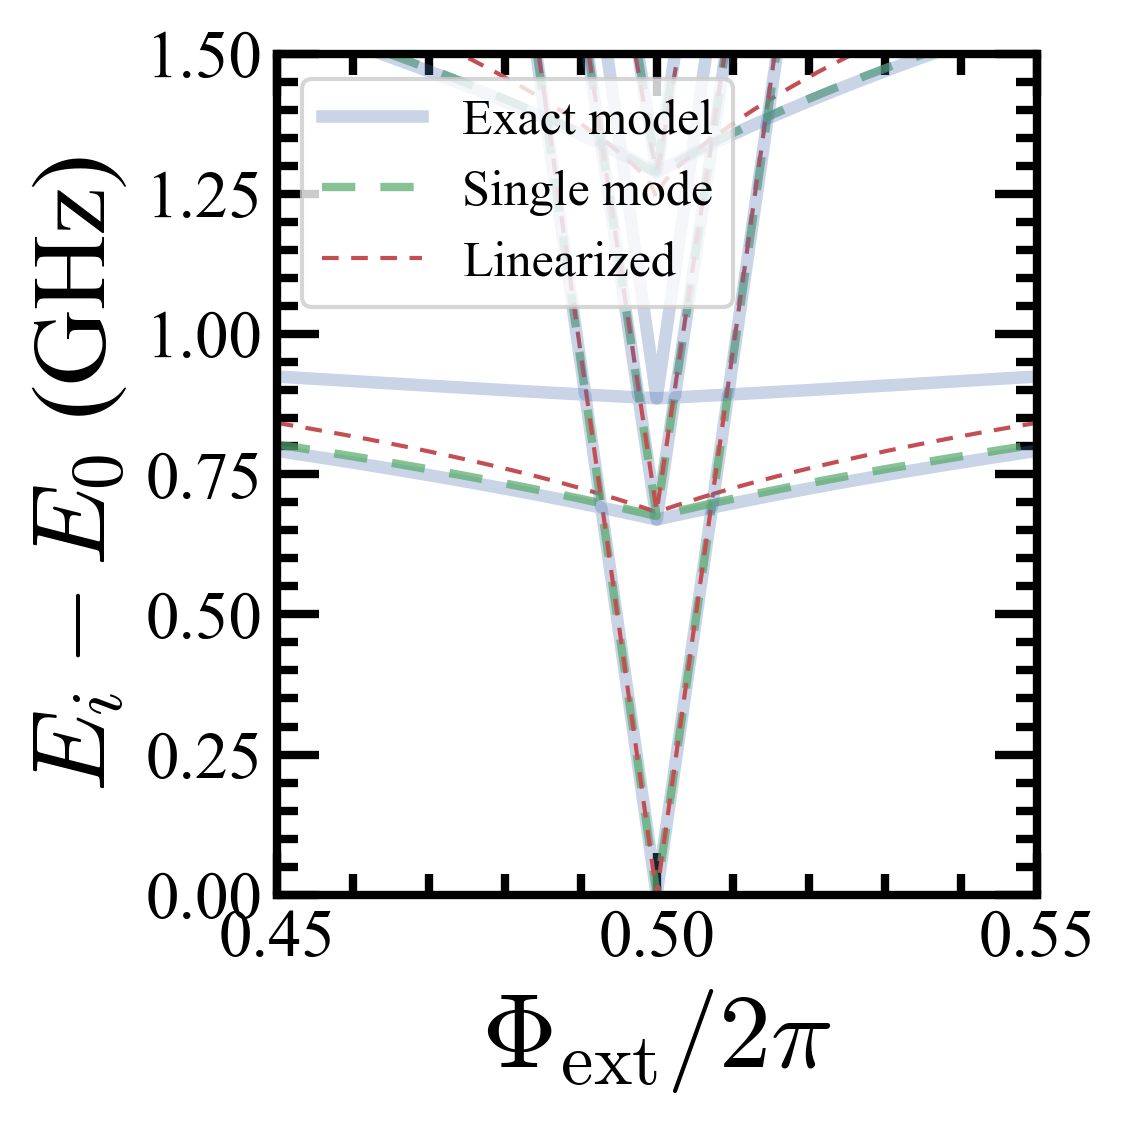

In [11]:
plt.figure(figsize = [4,4])
# for idx in range(0,10):
#     plt.plot(phi_ext_array / 2 / np.pi, energies[:,idx], linewidth = 1.0, alpha = 0.3)
for idx in range(1,10):
    line0, = plt.plot(phi_ext_array / 2 / np.pi, energies_full[:,idx]- energies_full[:,0],
         linewidth = 3.0, linestyle = '-',alpha = 0.3, color = 'C0')
    line1, = plt.plot(phi_ext_array / 2 / np.pi, energies_approx1[:,idx]- energies_approx1[:,0],
             linewidth = 2, linestyle = '--',alpha = 0.7, color = 'C1')
    line2, = plt.plot(phi_ext_array / 2 / np.pi, energies_approx2[:,idx]- energies_approx2[:,0],
             linewidth = 1.0, linestyle = '--', color = 'C2')
    
plt.xlim([phi_ext_array[0]/ 2 / np.pi, phi_ext_array[-1]/ 2 / np.pi])
plt.ylim([0,1.5])
plt.xlabel(r'$\Phi_\mathrm{ext}/2\pi$')
plt.ylabel(r'$E_i - E_0$ (GHz)')
line0.set_label('Exact model')
line1.set_label('Single mode')
line2.set_label('Linearized')
plt.legend(loc='upper left',prop={'size': 12})
plt.tight_layout()
if savefig == True:
    figname = 'flux_approx.pdf'
    plt.savefig(figpath+figname)

In [ ]:
x = np.linspace(-1,1,101)*np.pi
y = x**2 + 5*np.cos(x)
plt.plot(x,y)